In [1]:
import os, shutil, pathlib
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

2023-08-23 16:46:01.579227: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 16:46:01.619922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 16:46:02.177088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Create a smaller subset of dogs-vs-cats-db INTO training, validation, and test directories

In [2]:
original_dir = pathlib.Path('./dogs-vs-cats-db/train') # path to the directory where original dataset was uncompressed
new_base_dir = pathlib.Path('./cats_vs_dogs_small') # directory for our smaller dataset

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname, dst = dir / fname)

if not os.path.exists('./cats_vs_dogs_small'):
    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2500)

DATA AUGMENTATION NEEDED

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2023-08-23 16:46:02.838488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 16:46:02.858044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 16:46:02.858421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Setting up the architecture of the model

In [4]:
# model expects rgb images of size 180 x 180
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255) (x)#(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu") (x)
x = layers.Flatten() (x)
# augmentation
x = layers.Dropout(0.5) (x)

outputs = layers.Dense(1, activation="sigmoid") (x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
# model.summary()

In [6]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Use `image_dataset_from_directory(dir)` from Keras to read img into model

* list the subdirectories of `dir` and assumes each one contains images from one of the classes
* then index the image files in each subdirectory
* this creates and returns a `tf.data.Dataset` object, which is configured to...
> 1. read these files,
> 2. shuffle them,
> 3. decode them to tensors,
> 4. resize to shared size,
> 5. pack them into batches.

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [8]:
# displaying the shapes of the data and labels yielded by the 'Dataset' obj

for data_batch, labels_batch, in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.x",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [10]:
import nvidia.cudnn
print(nvidia.cudnn.__file__)

/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/nvidia/cudnn/__init__.py


In [11]:
# MODEL FIT into 'history'
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100


2023-08-23 16:46:05.741949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-08-23 16:46:06.742117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-23 16:46:06.743706: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd5c4151050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-23 16:46:06.743724: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2023-08-23 16:46:06.759118: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-23 16:46:06.872859: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

63/63 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.5090INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 8s 55ms/step - loss: 0.7004 - accuracy: 0.5090 - val_loss: 0.6918 - val_accuracy: 0.5200
Epoch 2/100
63/63 [==============================] - 2s 27ms/step - loss: 0.6972 - accuracy: 0.5230 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 3/100
61/63 [============================>.] - ETA: 0s - loss: 0.6923 - accuracy: 0.5184INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 2s 36ms/step - loss: 0.6920 - accuracy: 0.5200 - val_loss: 0.6840 - val_accuracy: 0.5640
Epoch 4/100
63/63 [==============================] - 2s 27ms/step - loss: 0.6810 - accuracy: 0.5750 - val_loss: 0.7673 - val_accuracy: 0.5050
Epoch 5/100
63/63 [==============================] - 2s 28ms/step - loss: 0.6681 - accuracy: 0.6145 - val_loss: 0.6875 - val_accuracy: 0.5810
Epoch 6/100
61/63 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6204INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 2s 36ms/step - loss: 0.6584 - accuracy: 0.6185 - val_loss: 0.6338 - val_accuracy: 0.6450
Epoch 7/100
63/63 [==============================] - 2s 28ms/step - loss: 0.6509 - accuracy: 0.6190 - val_loss: 0.6447 - val_accuracy: 0.6150
Epoch 8/100
61/63 [============================>.] - ETA: 0s - loss: 0.6288 - accuracy: 0.6598INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 3s 44ms/step - loss: 0.6285 - accuracy: 0.6610 - val_loss: 0.5963 - val_accuracy: 0.6700
Epoch 9/100
63/63 [==============================] - 2s 27ms/step - loss: 0.6119 - accuracy: 0.6750 - val_loss: 0.6048 - val_accuracy: 0.6620
Epoch 10/100
63/63 [==============================] - 2s 26ms/step - loss: 0.5975 - accuracy: 0.6855 - val_loss: 0.6150 - val_accuracy: 0.6490
Epoch 11/100
61/63 [============================>.] - ETA: 0s - loss: 0.6110 - accuracy: 0.7075INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 2s 36ms/step - loss: 0.6089 - accuracy: 0.7080 - val_loss: 0.5711 - val_accuracy: 0.7120
Epoch 12/100
63/63 [==============================] - 2s 26ms/step - loss: 0.5541 - accuracy: 0.7195 - val_loss: 0.6491 - val_accuracy: 0.6640
Epoch 13/100
61/63 [============================>.] - ETA: 0s - loss: 0.5281 - accuracy: 0.7392INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 3s 44ms/step - loss: 0.5276 - accuracy: 0.7405 - val_loss: 0.5378 - val_accuracy: 0.7240
Epoch 14/100
61/63 [============================>.] - ETA: 0s - loss: 0.5425 - accuracy: 0.7357INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 2s 36ms/step - loss: 0.5406 - accuracy: 0.7355 - val_loss: 0.5232 - val_accuracy: 0.7540
Epoch 15/100
63/63 [==============================] - 2s 25ms/step - loss: 0.5090 - accuracy: 0.7495 - val_loss: 0.5238 - val_accuracy: 0.7400
Epoch 16/100
61/63 [============================>.] - ETA: 0s - loss: 0.5298 - accuracy: 0.7418INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 2s 35ms/step - loss: 0.5286 - accuracy: 0.7415 - val_loss: 0.4832 - val_accuracy: 0.7650
Epoch 17/100
63/63 [==============================] - 2s 26ms/step - loss: 0.5186 - accuracy: 0.7550 - val_loss: 0.5028 - val_accuracy: 0.7410
Epoch 18/100
62/63 [============================>.] - ETA: 0s - loss: 0.5030 - accuracy: 0.7455INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 3s 45ms/step - loss: 0.5015 - accuracy: 0.7465 - val_loss: 0.4559 - val_accuracy: 0.7890
Epoch 19/100
63/63 [==============================] - 2s 26ms/step - loss: 0.4893 - accuracy: 0.7735 - val_loss: 0.4643 - val_accuracy: 0.7860
Epoch 20/100
63/63 [==============================] - 2s 26ms/step - loss: 0.4667 - accuracy: 0.7825 - val_loss: 0.5176 - val_accuracy: 0.7500
Epoch 21/100
63/63 [==============================] - 2s 26ms/step - loss: 0.4661 - accuracy: 0.7845 - val_loss: 0.5167 - val_accuracy: 0.7770
Epoch 22/100
61/63 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.7859INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 3s 42ms/step - loss: 0.4661 - accuracy: 0.7860 - val_loss: 0.4420 - val_accuracy: 0.7960
Epoch 23/100
63/63 [==============================] - 2s 26ms/step - loss: 0.4487 - accuracy: 0.7875 - val_loss: 0.4543 - val_accuracy: 0.7880
Epoch 24/100
61/63 [============================>.] - ETA: 0s - loss: 0.4479 - accuracy: 0.7966INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 2s 37ms/step - loss: 0.4460 - accuracy: 0.7970 - val_loss: 0.4353 - val_accuracy: 0.8030
Epoch 25/100
63/63 [==============================] - 2s 26ms/step - loss: 0.4249 - accuracy: 0.8065 - val_loss: 0.5711 - val_accuracy: 0.6980
Epoch 26/100
63/63 [==============================] - 2s 26ms/step - loss: 0.4348 - accuracy: 0.7965 - val_loss: 0.4773 - val_accuracy: 0.7600
Epoch 27/100
63/63 [==============================] - 2s 26ms/step - loss: 0.3968 - accuracy: 0.8275 - val_loss: 0.6824 - val_accuracy: 0.7170
Epoch 28/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3987 - accuracy: 0.8195 - val_loss: 0.4834 - val_accuracy: 0.7910
Epoch 29/100
61/63 [============================>.] - ETA: 0s - loss: 0.4022 - accuracy: 0.8207INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 2s 36ms/step - loss: 0.3986 - accuracy: 0.8225 - val_loss: 0.4275 - val_accuracy: 0.8150
Epoch 30/100
63/63 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8195INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 3s 42ms/step - loss: 0.3862 - accuracy: 0.8195 - val_loss: 0.4229 - val_accuracy: 0.8010
Epoch 31/100
63/63 [==============================] - 2s 26ms/step - loss: 0.3800 - accuracy: 0.8300 - val_loss: 0.4286 - val_accuracy: 0.8090
Epoch 32/100
63/63 [==============================] - 2s 25ms/step - loss: 0.3845 - accuracy: 0.8320 - val_loss: 0.4849 - val_accuracy: 0.7890
Epoch 33/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3595 - accuracy: 0.8400 - val_loss: 0.4722 - val_accuracy: 0.8130
Epoch 34/100
63/63 [==============================] - 2s 26ms/step - loss: 0.3753 - accuracy: 0.8285 - val_loss: 0.5111 - val_accuracy: 0.7970
Epoch 35/100
61/63 [============================>.] - ETA: 0s - loss: 0.3497 - accuracy: 0.8550INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 2s 37ms/step - loss: 0.3513 - accuracy: 0.8560 - val_loss: 0.4091 - val_accuracy: 0.8230
Epoch 36/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3462 - accuracy: 0.8475 - val_loss: 0.4301 - val_accuracy: 0.8090
Epoch 37/100
63/63 [==============================] - 2s 26ms/step - loss: 0.3341 - accuracy: 0.8590 - val_loss: 0.4233 - val_accuracy: 0.8260
Epoch 38/100
61/63 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8642INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 2s 36ms/step - loss: 0.3244 - accuracy: 0.8625 - val_loss: 0.3995 - val_accuracy: 0.8310
Epoch 39/100
63/63 [==============================] - 2s 26ms/step - loss: 0.3100 - accuracy: 0.8555 - val_loss: 0.6043 - val_accuracy: 0.7540
Epoch 40/100
61/63 [============================>.] - ETA: 0s - loss: 0.3290 - accuracy: 0.8622INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 3s 44ms/step - loss: 0.3264 - accuracy: 0.8630 - val_loss: 0.3946 - val_accuracy: 0.8420
Epoch 41/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2979 - accuracy: 0.8780 - val_loss: 0.4456 - val_accuracy: 0.8310
Epoch 42/100
63/63 [==============================] - 2s 28ms/step - loss: 0.2946 - accuracy: 0.8825 - val_loss: 0.5193 - val_accuracy: 0.8020
Epoch 43/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3044 - accuracy: 0.8710 - val_loss: 0.4120 - val_accuracy: 0.8390
Epoch 44/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2990 - accuracy: 0.8840 - val_loss: 0.4164 - val_accuracy: 0.8380
Epoch 45/100
63/63 [==============================] - 2s 26ms/step - loss: 0.2741 - accuracy: 0.8820 - val_loss: 0.8260 - val_accuracy: 0.7120
Epoch 46/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3020 - accuracy: 0.8800 - val_loss: 0.4332 - val_accuracy: 0.8440
Epoch 47/100

INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 3s 43ms/step - loss: 0.2369 - accuracy: 0.9010 - val_loss: 0.3884 - val_accuracy: 0.8590
Epoch 57/100
61/63 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9109INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 3s 45ms/step - loss: 0.2350 - accuracy: 0.9100 - val_loss: 0.3617 - val_accuracy: 0.8540
Epoch 58/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2203 - accuracy: 0.9155 - val_loss: 0.4374 - val_accuracy: 0.8530
Epoch 59/100
63/63 [==============================] - 2s 26ms/step - loss: 0.2305 - accuracy: 0.9110 - val_loss: 0.4180 - val_accuracy: 0.8630
Epoch 60/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2178 - accuracy: 0.9115 - val_loss: 0.4790 - val_accuracy: 0.8510
Epoch 61/100
63/63 [==============================] - 2s 26ms/step - loss: 0.2103 - accuracy: 0.9145 - val_loss: 0.4957 - val_accuracy: 0.8450
Epoch 62/100
63/63 [==============================] - 2s 28ms/step - loss: 0.2122 - accuracy: 0.9255 - val_loss: 0.4109 - val_accuracy: 0.8690
Epoch 63/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2007 - accuracy: 0.9205 - val_loss: 0.4550 - val_accuracy: 0.8580
Epoch 64/100

INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 3s 43ms/step - loss: 0.2047 - accuracy: 0.9155 - val_loss: 0.3537 - val_accuracy: 0.8590
Epoch 68/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2069 - accuracy: 0.9220 - val_loss: 0.4349 - val_accuracy: 0.8660
Epoch 69/100
63/63 [==============================] - 2s 26ms/step - loss: 0.1969 - accuracy: 0.9305 - val_loss: 0.6180 - val_accuracy: 0.8130
Epoch 70/100
63/63 [==============================] - 2s 26ms/step - loss: 0.1664 - accuracy: 0.9370 - val_loss: 0.7170 - val_accuracy: 0.8170
Epoch 71/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2053 - accuracy: 0.9225 - val_loss: 0.4246 - val_accuracy: 0.8530
Epoch 72/100
63/63 [==============================] - 2s 27ms/step - loss: 0.1941 - accuracy: 0.9215 - val_loss: 0.4410 - val_accuracy: 0.8440
Epoch 73/100
63/63 [==============================] - 2s 26ms/step - loss: 0.2290 - accuracy: 0.9100 - val_loss: 0.4473 - val_accuracy: 0.8510
Epoch 74/100

Plot training accuracy vs validation accuracy

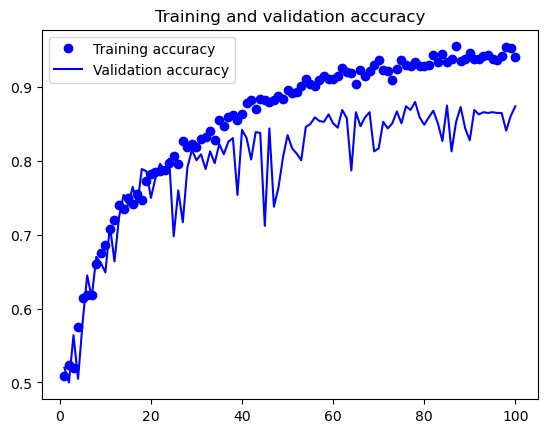

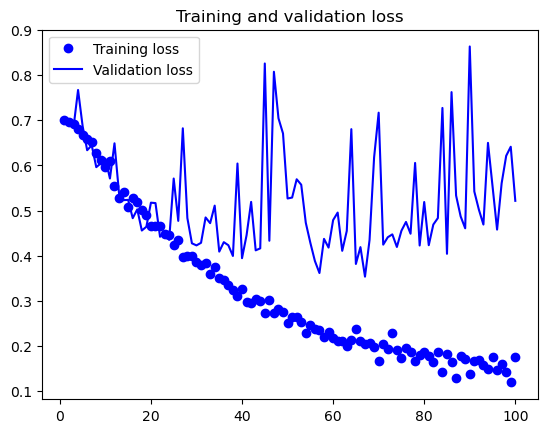

In [12]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

Evaluate model on test set

In [13]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 12ms/step - loss: 0.4510 - accuracy: 0.8350
Test accuracy: 0.835


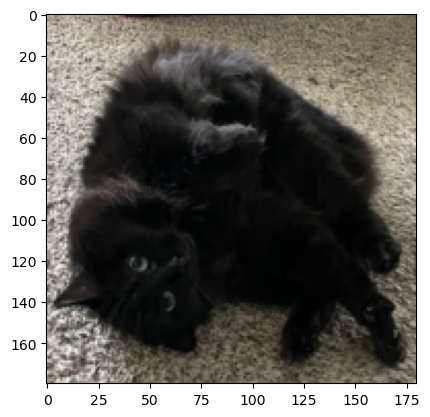

In [14]:
from PIL import Image

test_dog_path = './cats_vs_dogs_small/test/dog/dog.1507.jpg'
test_cat_path = './cats_vs_dogs_small/test/cat/cat.1500.jpg'
ivy = 'ivyBetter.png'
herbie = 'herbieSmall.png'

image = Image.open(ivy)

image = image.convert('RGB')
image = image.resize([180, 180])
plt.figure()
plt.imshow(image)

In [15]:
np_expanded_img = np.expand_dims(image, axis=0)
# img_scaled = np_expanded_img / 255.0

In [16]:
result = test_model.predict(np_expanded_img)
result

1/1 [==============================] - 0s 129ms/step


array([[0.11510807]], dtype=float32)

In [17]:
if result >= 0.5:
    print("THIS IS A VERY CUTE DOG :)")
else:
    print("THIS IS A VERY CUTE CAT :)")

THIS IS A VERY CUTE CAT :)
